In [5]:
import numpy as np
import random
from collections import defaultdict
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib.animation as animation
import time

In [6]:
class GridWorldEnv:
    def __init__(self, size=10, obstacles=None):
        self.size = size
        self.obstacles = obstacles if obstacles is not None else []
        self.reset()
        
    def reset(self, start=None, goal=None):
        """Reset environment with optional custom start/goal positions"""
        if start is None:
            self.start = self.get_random_position()
        else:
            self.start = start
            
        if goal is None:
            self.goal = self.get_random_position()
            while self.goal == self.start:
                self.goal = self.get_random_position()
        else:
            self.goal = goal
            
        self.current_pos = self.start
        return self.get_state()
    
    def get_random_position(self):
        """Get random position that's not an obstacle"""
        while True:
            pos = (random.randint(0, self.size-1), random.randint(0, self.size-1))
            if pos not in self.obstacles:
                return pos
    
    def get_state(self):
        """Return state as (current_position, goal_position)"""
        return (self.current_pos, self.goal)
    
    def step(self, action):
        """Take action and return (new_state, reward, done)"""
        # Actions: 0=up, 1=right, 2=down, 3=left
        moves = [(-1, 0), (0, 1), (1, 0), (0, -1)]
        
        # Calculate new position
        new_pos = (
            self.current_pos[0] + moves[action][0],
            self.current_pos[1] + moves[action][1]
        )
        
        # Check if move is valid
        if (0 <= new_pos[0] < self.size and 
            0 <= new_pos[1] < self.size and 
            new_pos not in self.obstacles):
            self.current_pos = new_pos
            
        # Calculate reward
        if self.current_pos == self.goal:
            reward = 100
            done = True
        else:
            reward = -1
            done = False
            
        return self.get_state(), reward, done

class QLearningAgent:
    def __init__(self, action_space=4, learning_rate=0.1, discount_factor=0.95, epsilon=0.1):
        self.q_table = defaultdict(lambda: np.zeros(action_space))
        self.lr = learning_rate
        self.gamma = discount_factor
        self.epsilon = epsilon
    
    def get_action(self, state):
        """Epsilon-greedy action selection"""
        if random.random() < self.epsilon:
            return random.randint(0, 3)
        return np.argmax(self.q_table[state])
    
    def update(self, state, action, reward, next_state):
        """Update Q-value for state-action pair"""
        best_next_action = np.argmax(self.q_table[next_state])
        td_target = reward + self.gamma * self.q_table[next_state][best_next_action]
        td_error = td_target - self.q_table[state][action]
        self.q_table[state][action] += self.lr * td_error

In [7]:
class GridVisualizer:
    def __init__(self, env):
        self.env = env
        self.fig, self.ax = plt.subplots(figsize=(8, 8))
        self.images = []
        
    def draw_grid(self, path=None, current_pos=None):
        """Draw the grid with optional path and current position"""
        self.ax.clear()
        
        # Draw grid lines
        for i in range(self.env.size + 1):
            self.ax.axhline(y=i, color='gray', linestyle='-', alpha=0.3)
            self.ax.axvline(x=i, color='gray', linestyle='-', alpha=0.3)
            
        # Draw obstacles
        for obs in self.env.obstacles:
            self.ax.add_patch(Rectangle((obs[1], obs[0]), 1, 1, facecolor='gray'))
            
        # Draw start and goal
        self.ax.add_patch(Rectangle((self.env.start[1], self.env.start[0]), 1, 1, facecolor='green', alpha=0.5))
        self.ax.add_patch(Rectangle((self.env.goal[1], self.env.goal[0]), 1, 1, facecolor='red', alpha=0.5))
        
        # Draw path
        if path:
            path_x = [p[1] + 0.5 for p in path]
            path_y = [p[0] + 0.5 for p in path]
            self.ax.plot(path_x, path_y, 'b-', linewidth=2, alpha=0.5)
            
        # Draw current position
        if current_pos:
            self.ax.add_patch(Rectangle((current_pos[1], current_pos[0]), 1, 1, facecolor='blue', alpha=0.5))
            
        self.ax.set_xlim(0, self.env.size)
        self.ax.set_ylim(0, self.env.size)
        self.ax.invert_yaxis()
        plt.grid(True)
        
    def animate_path(self, path, interval=500):
        """Animate the agent moving along the path"""
        def update(frame):
            self.draw_grid(path[:frame+1], path[frame])
            return self.ax,
            
        anim = animation.FuncAnimation(
            self.fig, update, frames=len(path),
            interval=interval, blit=True, repeat=False
        )
        plt.close()
        return anim

In [19]:
def train(episodes=1000, visualize_every=100):
    env = GridWorldEnv(size=10)
    agent = QLearningAgent()
    visualizer = GridVisualizer(env)
    
    for episode in range(episodes):
        state = env.reset()
        total_reward = 0
        done = False
        path = [env.start]
        
        while not done:
            action = agent.get_action(state)
            next_state, reward, done = env.step(action)
            agent.update(state, action, reward, next_state)
            state = next_state
            total_reward += reward
            path.append(env.current_pos)
            
        if episode % visualize_every == 0:
            print(f"Episode {episode}, Total Reward: {total_reward}")
    
    return agent

def find_path_and_visualize(agent, env, start, goal, animate=True):
    """Find path and visualize it with optional animation"""
    path = [start]
    current_state = env.reset(start=start, goal=goal)
    done = False
    
    while not done and len(path) < 100:
        action = agent.get_action(current_state)
        print(action)
        next_state, reward, done = env.step(action)
        path.append(next_state[0])
        current_state = next_state
    
    print(f"Path length: {len(path)-1}")
    print(f"Path: {path}")
    visualizer = GridVisualizer(env)
    if animate:
        return visualizer.animate_path(path)
    else:
        visualizer.draw_grid(path)
        plt.show()
        return path

Episode 0, Total Reward: 19
Episode 200, Total Reward: 59
Episode 400, Total Reward: -104
Episode 600, Total Reward: -43
Episode 800, Total Reward: 33


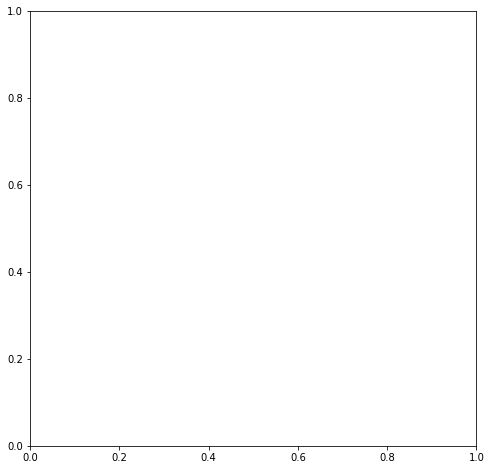

In [16]:

# Create environment with some obstacles
obstacles = [(2, 2), (2, 3), (2, 4), (3, 2), (4, 2)]
env = GridWorldEnv(size=10, obstacles=obstacles)

# Train the agent
trained_agent = train(episodes=1000, visualize_every=200)


In [20]:
# Test and visualize with specific start and goal positions
start_pos = (0, 0)
goal_pos = (9, 9)
anim = find_path_and_visualize(trained_agent, env, start_pos, goal_pos, animate=True)
plt.show()

0
0
0
0
0
0
2
2
2
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
2
3
3
2
0
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
2
0
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
Path length: 99
Path: [(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (1, 0), (2, 0), (3, 0), (3, 0), (3, 0), (3, 0), (3, 0), (3, 0), (3, 0), (3, 0), (3, 0), (3, 0), (3, 0), (3, 0), (3, 0), (3, 0), (3, 0), (3, 0), (3, 0), (3, 0), (3, 0), (3, 0), (3, 0), (3, 0), (3, 0), (3, 0), (3, 0), (3, 0), (3, 0), (4, 0), (4, 0), (4, 0), (5, 0), (4, 0), (4, 0), (4, 0), (4, 0), (4, 0), (4, 0), (4, 0), (4, 0), (4, 0), (4, 0), (4, 0), (4, 0), (4, 0), (4, 0), (4, 0), (4, 0), (4, 0), (5, 0), (4, 0), (4, 0), (4, 0), (4, 0), (4, 0), (4, 0), (4, 0), (4, 0), (4, 0), (4, 0), (4, 0), (4, 0), (4, 0), (4, 0), (4, 0), (4, 0), (4, 0), (4, 0), (4, 0), (4, 0), (4, 0), (4, 0), (4, 0), (4, 0), (4, 0), (4, 0), (4, 0), (4, 0), (4, 0), (4, 0), (4, 0), (4, 0), (4, 0), (4, 0), (4, 0), (4, 0), (4, 0), (4, 0), (4, 0), (4,